# Correlation EDA and Feature Generation
- Examine feature reduction possibilities using correlation analysis.
- Use data attributes to generate feature coverage tables.
- Note that the language used in this notebook (ie. attributes, features, examples, etc.) is from "Foundations of Rule Learning" (Springer) by Furnkranz, Gamberger and Lavrac.

    Copyright (C) 2022 Geoffrey Guy Messier

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import numpy as np
import pandas as pd
import datetime, copy, imp
import time
import matplotlib.pyplot as plt
import pickle


from tqdm.auto import tqdm, trange
from tqdm.notebook import tqdm
tqdm.pandas()

import sys
sys.path.insert(0, '../util/')

%aimport di_data
%aimport data_cache

from di_data import *
from data_cache import CacheResult
from rules import gen_coverage_table

## Load Data

In [3]:
#dataDirStr = '/hd2/data/di/plwh/'
#cacheDirStr = '/hd2/data/di/plwh/cache/'

dataDirStr = '/Users/gmessier/data/plwh/'
cacheDirStr = '/Users/gmessier/data/plwh/cache/'

In [4]:
winSizes = [ 30, 60, 90, 120 ]
tbl = {}
for win in winSizes:
    tbl[win] = pd.read_hdf(cacheDirStr + 'DiRules-EvaluationData.hd5', key='Win{}'.format(win))

## Create Examples
- An example consists of a row of the attribute matrix plus a value from the label vector.
- Since only active clients are considered, the number of examples for each window size will not include the same client cohort.

In [5]:
# Columns that will be used for example attributes.
attrCols = [ 
    'EntrySleep', 'EntryConsl', 'EntryLog', 'EntryBar', 'Addiction', 'Bar',
    'PhysicalHealth', 'MentalHealth', 'Violence', 'PoliceJustice',
    'Conflict', 'EMS', 'Supports', 'Overdose' ]

# Column used for example label.
labelCol = [ 'Label' ]

In [6]:
# In the following, only data from clients who are defined as active are included as examples.
attr = {}  # The attribute matrices.
lbl = {}   # The label vectors.
clientIds = {}  #  Vector of client IDs included as examples.
evalTimes = {}  #  Time elapsed before each client is evaluated.

for win in winSizes:
    # Example attributes.
    attr[win] = tbl[win].loc[tbl[win].Active == 1, attrCols].to_numpy(dtype=float)
    attr[win][np.isnan(attr[win])] = 0
    
    # Example labels.
    lbl[win] = tbl[win].loc[tbl[win].Active == 1, labelCol].to_numpy(dtype=float)
    
    # Example client ID's.
    clientIds[win] = tbl[win].loc[tbl[win].Active == 1].index.to_numpy(dtype=int)
    
    # Example elapsed time to evaluation (days).
    evalTimes[win] = tbl[win].loc[tbl[win].Active == 1].EvalTime.to_numpy(dtype=int)
    
    nSel = len(clientIds[win])
    nTot = len(tbl[win].index)
    print('WinSize: {}, Selected {}/{} ({:.2f}%) clients.'.format(win,nSel,nTot,100*nSel/nTot))
    

WinSize: 30, Selected 12175/32346 (37.64%) clients.
WinSize: 60, Selected 8671/32346 (26.81%) clients.
WinSize: 90, Selected 7440/32346 (23.00%) clients.
WinSize: 120, Selected 6650/32346 (20.56%) clients.


In [7]:
print('--- Attribute Index Number Key ---\n')
for idx in range(len(attrCols)):
    print('{}: {}'.format(idx,attrCols[idx]))

--- Attribute Index Number Key ---

0: EntrySleep
1: EntryConsl
2: EntryLog
3: EntryBar
4: Addiction
5: Bar
6: PhysicalHealth
7: MentalHealth
8: Violence
9: PoliceJustice
10: Conflict
11: EMS
12: Supports
13: Overdose


## Attribute Cross Correlation

In [8]:
attXCor = {} # Attribute cross-correlation for each window size.
for win in winSizes:
    attXCor[win] = np.corrcoef(attr[win],rowvar=False)

In [9]:
def crosscorr_table_print(cc,cols,colWdth):
    strFmt = '{0:>%d}' % colWdth
    numFmt = '{:%d.2f}' % colWdth
    
    print(strFmt.format(''),end='')
    for col in cols:
        print(strFmt.format(col[0:colWdth-1]),end='')
    print('')

    for i in range(cc.shape[0]):
        print(strFmt.format(cols[i][0:colWdth-1]),end='')
        for j in range(cc.shape[1]):
            print(numFmt.format(cc[i,j]),end='')
        print('')

In [10]:
def crosscorr_table_heatmap(cc,cols):
    f = plt.figure(figsize=(15, 10))
    plt.matshow(cc, fignum=f.number)
    plt.xticks(range(len(cols)), cols, fontsize=10, rotation=45)
    plt.yticks(range(len(cols)), cols, fontsize=10)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16);

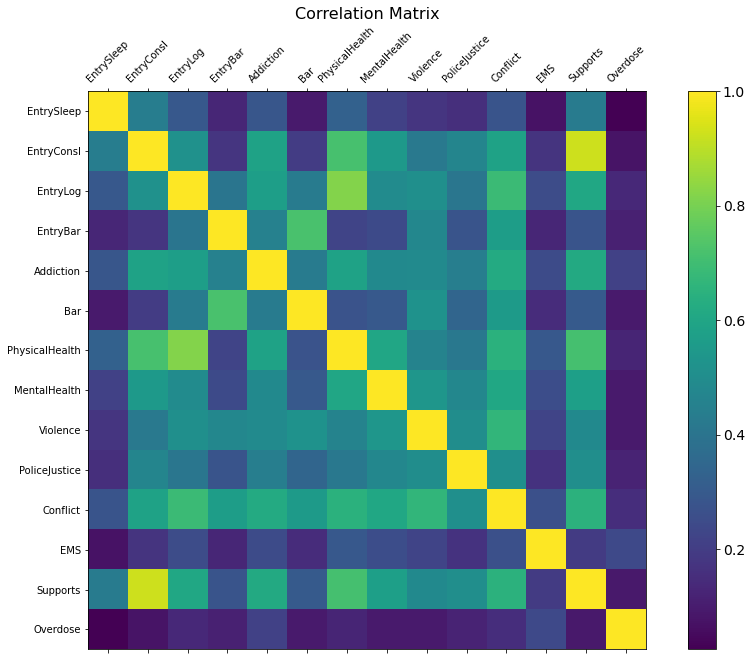

In [11]:
crosscorr_table_heatmap(attXCor[30],attrCols)

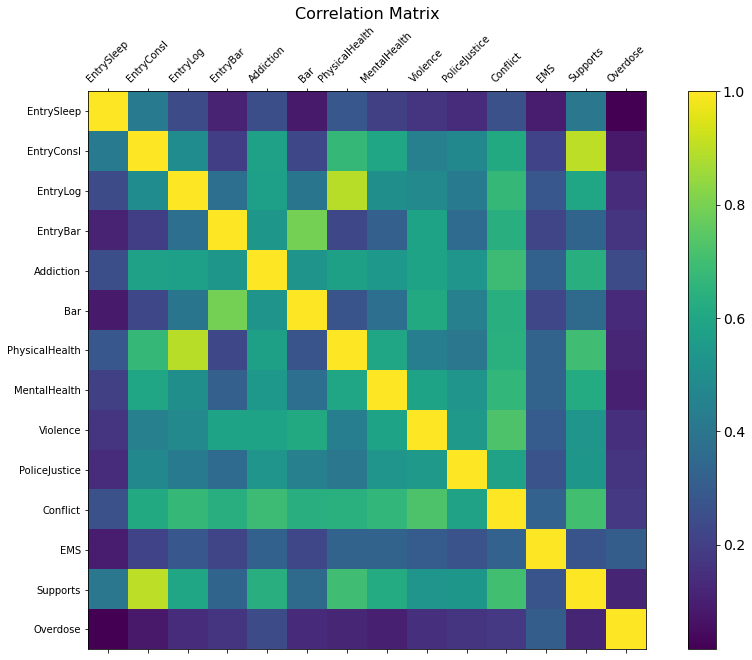

In [12]:
crosscorr_table_heatmap(attXCor[120],attrCols)

## Attribute to Label Correlation

In [13]:
lblAttrCor = {}

for win in winSizes:
    lblAttrCor[win] = np.zeros(len(attrCols))
    lblMn = np.mean(lbl[win])
    lblVr = np.var(lbl[win])

    for idx in range(len(attrCols)):
        attrV = attr[win][:,idx][:,None]
        lblAttrCor[win][idx] = (np.mean(attrV*lbl[win]) - lblMn*np.mean(attrV))/np.sqrt(lblVr*np.var(attrV))

In [14]:
def print_label_correlations(cor,cols):
    for idx in range(len(cols)):
        print('{}. {}: {:.2f}'.format(idx,cols[idx],cor[idx]))

In [15]:
print('==== Attribute to Label Correlation ====\n')

for win in winSizes:
    print('\n--- Win Size: {} ---'.format(win))
    print_label_correlations(lblAttrCor[win],attrCols)

==== Attribute to Label Correlation ====


--- Win Size: 30 ---
0. EntrySleep: 0.39
1. EntryConsl: 0.05
2. EntryLog: 0.02
3. EntryBar: -0.04
4. Addiction: 0.00
5. Bar: -0.04
6. PhysicalHealth: 0.04
7. MentalHealth: -0.00
8. Violence: -0.03
9. PoliceJustice: -0.03
10. Conflict: -0.01
11. EMS: -0.02
12. Supports: 0.04
13. Overdose: -0.02

--- Win Size: 60 ---
0. EntrySleep: 0.45
1. EntryConsl: 0.06
2. EntryLog: 0.02
3. EntryBar: -0.06
4. Addiction: -0.01
5. Bar: -0.06
6. PhysicalHealth: 0.05
7. MentalHealth: -0.01
8. Violence: -0.05
9. PoliceJustice: -0.04
10. Conflict: -0.02
11. EMS: -0.02
12. Supports: 0.03
13. Overdose: -0.03

--- Win Size: 90 ---
0. EntrySleep: 0.51
1. EntryConsl: 0.09
2. EntryLog: 0.04
3. EntryBar: -0.07
4. Addiction: -0.00
5. Bar: -0.07
6. PhysicalHealth: 0.07
7. MentalHealth: 0.00
8. Violence: -0.05
9. PoliceJustice: -0.03
10. Conflict: -0.01
11. EMS: -0.02
12. Supports: 0.06
13. Overdose: -0.04

--- Win Size: 120 ---
0. EntrySleep: 0.57
1. EntryConsl: 0.12
2. Ent

## Feature Pruning

This routine ranks features in the order they should be retained.  Features more likely to be discarded are candidates that are strongly correlated with another feature and not that correlated with the outcome.  The best features should be highly correlated with the outcome and not correlated with other features.  In practice, it appears that the disadvantage of high correlation with other features trumps the advantage of high correlation with the outcome.

Specifically, this routine does the following:
1. Sort pairs according to decreasing cross correlation with their partners.  Once a feature is included in a pair during an iteration, it's no longer available for other pairs.
1. For each pair, remove the feature that's least correlated with the outcome.
1. Repeat these two steps until there are no more features.
1. Select features in the reverse order of elimination.

In [16]:
def correlation_feature_prune(xcor,lcor,keep=[]):
    '''
    xcor - Attribute cross correlation matrix.
    lcor - Attribute to label cross correlation vector.
    keep - Integer indices of attributes that must be kept.  Excluded from the ranking.
    '''

    # Removes a feature from the cross correlation table by zeroing it's correlation values.
    def BlankFeature(cor,i):
        cor[i,:] = 0
        cor[:,i] = 0
    

    nFtr = xcor.shape[0]
    nFtrRem = xcor.shape[0] - len(keep)  # Number of features remaining.
    elim = []                          # Ordered set of eliminated features.

    while nFtrRem > 0: 
        nPairs = int(nFtrRem/2)
        pairs = []
        
        # Create a temporary copy of the cross correlation matrix.
        xcorTmp = np.abs(np.triu(xcor,k=1))

        # Remove any features that must be kept from the comparison by zeroing them in the
        # cross corrleation matrix.
        for iKeep in keep:
            BlankFeature(xcorTmp,iKeep)

        # Zero out any features that have been eliminated in previous iterations.
        for iElim in elim:
            BlankFeature(xcorTmp,iElim)
            
        # Special case of only one feature left (ie. no more pairs).
        if nFtrRem == 1:
            lastFtr = [ ftr for ftr in range(nFtr) if not any(np.isin(elim,ftr))][0]            
            elim.append(lastFtr)
            nFtrRem -= 1

        # We have at least one pair of features that needs to be evaluated.
        else:

            for iPair in range(nPairs):
                
                # Finds the two features with the highest cross correlation value.
                pair = np.unravel_index(np.argmax(xcorTmp, axis=None), xcorTmp.shape)
                
                # Blank both features so neither pair member will be evaluated this iteration.
                # Note: The feature that remains will still be evaluated next iteration since
                #       we're working with a temporary copy of the cross correlation matrix.
                BlankFeature(xcorTmp,pair[0])
                BlankFeature(xcorTmp,pair[1])
                
                # Eliminate the pair member with the lowest correlation with the output feature.
                drop = np.argmin([ np.abs(lcor[pair[0]]), np.abs(lcor[pair[1]]) ])
                elim.append(pair[drop])

                nFtrRem -= 1

    return reversed(elim)

In [17]:
# Do a correlation prune on all features.
for win in winSizes:

    features = correlation_feature_prune(attXCor[win],lblAttrCor[win])

    print('\n-- Feature Retention Order (Win Size: {}) --'.format(win))
    for feature in features:
        print('{:2d}: {: <15} (label corr: {:.3f})'.format(feature,attrCols[feature],lblAttrCor[win][feature]))   


-- Feature Retention Order (Win Size: 30) --
 0: EntrySleep      (label corr: 0.391)
 8: Violence        (label corr: -0.029)
13: Overdose        (label corr: -0.024)
 1: EntryConsl      (label corr: 0.053)
 3: EntryBar        (label corr: -0.037)
 4: Addiction       (label corr: 0.003)
 6: PhysicalHealth  (label corr: 0.042)
 9: PoliceJustice   (label corr: -0.033)
11: EMS             (label corr: -0.015)
 7: MentalHealth    (label corr: -0.001)
10: Conflict        (label corr: -0.010)
 5: Bar             (label corr: -0.037)
 2: EntryLog        (label corr: 0.016)
12: Supports        (label corr: 0.037)

-- Feature Retention Order (Win Size: 60) --
 0: EntrySleep      (label corr: 0.451)
 3: EntryBar        (label corr: -0.059)
 1: EntryConsl      (label corr: 0.060)
 8: Violence        (label corr: -0.047)
13: Overdose        (label corr: -0.032)
 4: Addiction       (label corr: -0.013)
 6: PhysicalHealth  (label corr: 0.051)
 9: PoliceJustice   (label corr: -0.044)
11: EMS        

## Coverage Table

In [19]:
for win in winSizes:
    
    print('--- Window Size: {} ---'.format(win))
    (ftrStr,attrInds,vs,ops,covTbl,lbls) = gen_coverage_table(attr[win],lbl[win])
    print('Number of Features: {}\n'.format(len(ftrStr)))
    
#    covFileStr = '/hd2/data/di/plwh/cache/DiRules-CoverageTable-WinSz{}.pkl'.format(win)
    covFileStr = '/Users/gmessier/data/plwh/cache/DiRules-CoverageTable-WinSz{}.pkl'.format(win)
    pklFile = open(covFileStr,'wb',buffering=0)
    pickle.dump({ 
        'FeatureStrings': ftrStr, 
        'AttributeIndices': attrInds, 
        'ThresholdValues': vs, 
        'FeatureOperations': ops, 
        'CoverageTable': covTbl, 
        'Labels': lbls, 
        'ClientIds': clientIds[win], 
        'IdTimes': evalTimes[win] }, pklFile)
    pklFile.close()

--- Window Size: 30 ---
 Number of Examples: 12175
  Attribute 0 Features: 123 (124 unique values)
  Attribute 1 Features: 55 (62 unique values)
  Attribute 2 Features: 53 (63 unique values)
  Attribute 3 Features: 12 (15 unique values)
  Attribute 4 Features: 22 (28 unique values)
  Attribute 5 Features: 16 (19 unique values)
  Attribute 6 Features: 49 (62 unique values)
  Attribute 7 Features: 26 (29 unique values)
  Attribute 8 Features: 20 (21 unique values)
  Attribute 9 Features: 20 (23 unique values)
  Attribute 10 Features: 29 (34 unique values)
  Attribute 11 Features: 8 (10 unique values)
  Attribute 12 Features: 52 (59 unique values)
  Attribute 13 Features: 6 (9 unique values)
Number of Features: 491

--- Window Size: 60 ---
 Number of Examples: 8671
  Attribute 0 Features: 183 (184 unique values)
  Attribute 1 Features: 69 (78 unique values)
  Attribute 2 Features: 67 (81 unique values)
  Attribute 3 Features: 16 (21 unique values)
  Attribute 4 Features: 30 (34 unique val